In [5]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [3]:
row = cat.iloc[20]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1971, 4, 13, 12, 55)

In [4]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

46500.0

In [5]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1971-04-13HR02_evid00029'

In [68]:
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
mseed_file = "./data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed"
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-03-14T00:00:00.520000Z - 1970-03-15T00:00:03.840755Z | 6.6 Hz, 572423 samples

In [69]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

34174499.48

In [70]:
# Set the minimum frequency
minfreq = 0.1
maxfreq = 3

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [11]:
from scipy import signal
from matplotlib import cm

def plot(tr_data, tr):
    f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)
    print(len(t))
    freq_mask = (f >= 0.25) & (f <= 1.2)
    f = f[freq_mask]
    sxx = sxx[freq_mask, :]
    end_time = arrival + 6000
    time_mask = (t >= arrival) & (t <= end_time)
    t = t[time_mask]
    sxx = sxx[:, time_mask]


    print(len(t))
    print(len(f))


    print(f)
    print(t)
    print(sxx)

plot(tr_data_filt, tr_filt)

NameError: name 'tr_data_filt' is not defined

2555


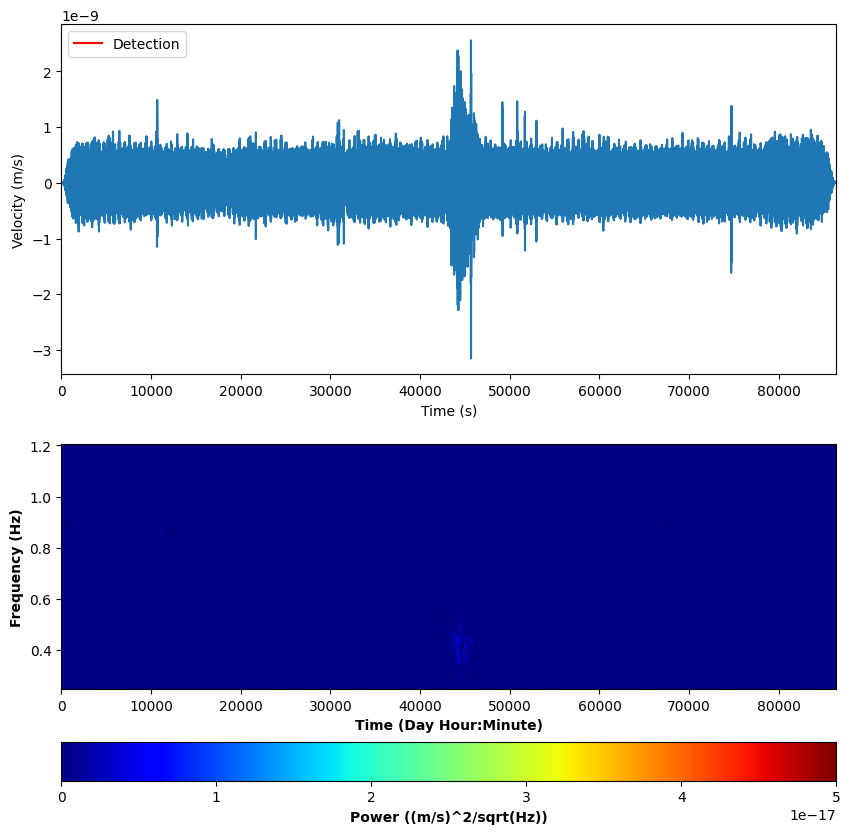

In [72]:
# Plot the time series and spectrogram

f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)
print(len(t))
freq_mask = (f >= 0.25) & (f <= 1.2)
f = f[freq_mask]
sxx = sxx[freq_mask, :]
# end_time = arrival + 6000
# time_mask = (t >= arrival) & (t <= end_time)
# t = t[time_mask]
# sxx = sxx[:, time_mask]

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

In [21]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load large image
def load_image(data_directory, image_path):
    # return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    

    mseed_file = f'{data_directory}{image_path}.mseed'
    # mseed_file = "./data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed"
    st = read(mseed_file)

    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    # arrival = (arrival_time - starttime).total_seconds()

    f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)
    # print(len(t))
    freq_mask = (f >= 0.25) & (f <= 1.2)
    f = f[freq_mask]
    sxx = sxx[freq_mask, :]
    # end_time = arrival + 6000
    # time_mask = (t >= arrival) & (t <= end_time)
    # t = t[time_mask]
    # sxx = sxx[:, time_mask]

    return sxx, tr_times, t



# Sliding window function
def sliding_window(image, window_size, step_size):
    for x in range(0, image.shape[1] - window_size[1] + 1, step_size):
        # print(image.shape[0])
        yield x, image[:, x:x + window_size[1]]

def create_dataset(images, coordinates, window_size, step_size):
    samples, labels, positions = [], [], []
    positives = 0
    positive_samples = []  # Store positive sub-images
    for image, y_coord in zip(images, coordinates):
        for x, sub_image in sliding_window(image, window_size, step_size):
            if y_coord >= x and y_coord <= (x + window_size[1] * 0.8):
                label = 1  # Positive sample
                positives += 1
                positive_samples.append(sub_image)  # Add positive sub-image to the list
            else:
                label = 0  # Negative sample

            sub_image_resized = cv2.resize(sub_image, (window_size[1], window_size[0]))
            samples.append(sub_image_resized)
            labels.append(label)
            positions.append(x)  # Store the position of the sliding window

    print(f"Number of positive samples: {positives}")
    return np.array(samples), np.array(labels), positions, positive_samples

def plot_positive_samples(positive_samples):
    # Plot positive sub-images
    num_samples = len(positive_samples)
    plt.figure(figsize=(15, 5))

    # Display positive samples
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(positive_samples[i], cmap='gray')
        plt.axis('off')  # Turn off axis
        plt.title(f'Positive Sample {i + 1}')

    plt.tight_layout()
    plt.show()

# Define a simple CNN model
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),  # Flatten input shape to 1D
        tf.keras.layers.Dense(200, activation='relu'),     # First dense layer
        tf.keras.layers.Dropout(0.5),                      # Dropout layer with 50% dropout rate
        tf.keras.layers.Dense(100, activation='relu'),     # Second dense layer
        tf.keras.layers.Dropout(0.5),                      # Dropout layer with 50% dropout rate
        tf.keras.layers.Dense(1, activation='sigmoid')     # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the CNN
def train_model(x_train, y_train, x_val, y_val, input_shape):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    model = build_model(input_shape)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=16, class_weight=class_weight_dict)
    return model




Number of positive samples: 256


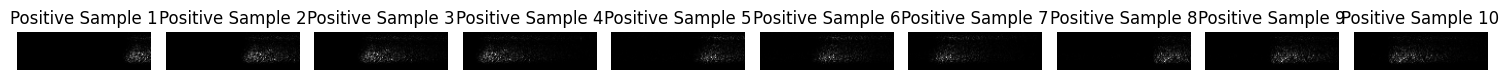

In [25]:
# Main script

cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

data_directory = './data/lunar/training/data/S12_GradeA/'

image_paths = cat["filename"]  # List of image paths
images = [load_image(data_directory, path)[0] for path in image_paths]
timestamps = [load_image(data_directory, path)[1] for path in image_paths]
t = [load_image(data_directory, path)[2] for path in image_paths]
y_coordinates = [np.argmax(image_timestamps > timestamp) for image_timestamps, timestamp in zip(t, cat["time_rel(sec)"])]  # Corresponding y-coordinates where the target starts for each image

window_size = (37, 130)  # (height, width)
step_size = 30

# Load images

# print(image_paths)
# Create dataset
samples, labels, postitions, positivvvs = create_dataset(images, y_coordinates, window_size, step_size)
# Bestimme den globalen Maximalwert für alle Samples
global_max = np.max(samples)

# Normalisiere die Samples (Wertebereich von 0 bis 1) durch den globalen Maximalwert
samples = samples / global_max



plot_positive_samples(positivvvs[:10])

# Expand dimensions to add channel information for CNN input
# samples = np.expand_dims(samples, axis=-1)



1 30
Number of positive samples: 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[0.2799349 ]
 [0.30475378]
 [0.82948923]
 [0.8850982 ]
 [0.84260434]
 [0.6603021 ]
 [0.25614572]
 [0.2995261 ]
 [0.4210419 ]
 [0.8681079 ]
 [0.8442638 ]
 [0.78829324]
 [0.40673286]
 [0.28404018]
 [0.32206702]
 [0.32267314]
 [0.32653156]
 [0.31817293]
 [0.3189612 ]
 [0.3286866 ]
 [0.3241637 ]
 [0.3307818 ]
 [0.33394605]
 [0.318791  ]
 [0.32300416]
 [0.31616637]
 [0.31596842]
 [0.31226367]
 [0.3129715 ]
 [0.31500098]
 [0.3295847 ]
 [0.33519801]
 [0.32627374]
 [0.30518627]
 [0.29694104]
 [0.29941186]
 [0.30458227]
 [0.30722985]
 [0.3206806 ]
 [0.33135238]
 [0.33256036]
 [0.33165812]
 [0.32578662]
 [0.3192236 ]
 [0.3215241 ]
 [0.34950593]
 [0.36014384]
 [0.34933516]
 [0.3326175 ]
 [0.30643973]
 [0.3049173 ]
 [0.30251655]
 [0.30607888]
 [0.28241545]
 [0.23645736]
 [0.2321112 ]
 [0.24194418]
 [0.29103205]
 [0.30177996]
 [0.31724834]
 [0.320555  ]
 [0.31660816]
 [0.3121658 ]
 [0.5259919 ]
 [0.58609474]
 [0.5022948 ]
 [0

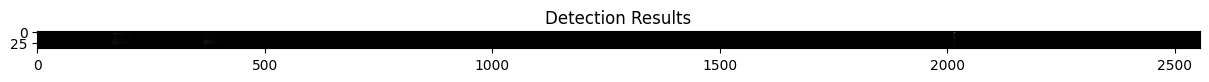

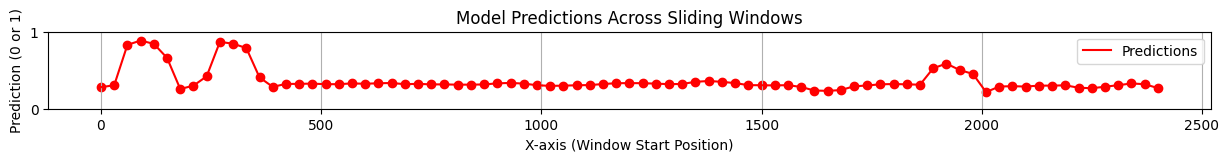

In [31]:
# test engegner script

# cat_directory = './data/lunar/training/catalogs/'
# cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
# cat = pd.read_csv(cat_file)
# cat
path = "xa.s12.00.mhz.1970-02-18HR00_evid00016"
data_directory = "./data/lunar/test/data/S12_GradeB/"

path = "xa.s12.00.mhz.1970-03-14HR00_evid00018"
data_directory = "./data/lunar/test/data/S12_GradeB/"

path = "xa.s12.00.mhz.1970-02-07HR00_evid00014"
data_directory = "./data/lunar/test/data/S12_GradeB/"

# path = "xa.s12.00.mhz.1970-01-19HR00_evid00002"
# data_directory = "./data/lunar/training/data/S12_GradeA/"
# mseed_file = "./data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed"
# image_paths = cat["filename"]  # List of image paths
images = [load_image(data_directory, path)[0]]

print(len(images), step_size)

timestamps = [load_image(data_directory, path)[1]]
t = [load_image(data_directory, path)[2]]
y_coordinates = np.zeros(len(images))  # Corresponding y-coordinates where the target starts for each image

window_size = (37, 130)  # (height, width)
step_size = 30

# Load images

# print(image_paths)
# Create dataset
samples, labels, postitions, positivvvs = create_dataset(images, y_coordinates, window_size, step_size)
# Bestimme den globalen Maximalwert für alle Samples
# global_max = np.max(samples)

# Normalisiere die Samples (Wertebereich von 0 bis 1) durch den globalen Maximalwert
samples = samples / global_max



# plot_positive_samples(positivvvs)

model = tf.keras.models.load_model('cnn_detector.h5')

# Expand dimensions to add channel information for CNN input
# samples = np.expand_dims(samples, axis=-1)
predictions = model.predict(samples)
print(predictions)

# Plot the original image and draw red lines at detected regions
plt.figure(figsize=(15, 50))
plt.imshow(images[0], cmap='gray')
plt.title('Detection Results')

plt.figure(figsize=(15, 1))
plt.plot(postitions, predictions, 'r-', label='Predictions')
plt.scatter(postitions, predictions, color='red')  # Scatter plot for better visibility
plt.xlabel('X-axis (Window Start Position)')
plt.ylabel('Prediction (0 or 1)')
plt.title('Model Predictions Across Sliding Windows')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()
plt.show()


In [16]:
# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(samples, labels, test_size=0.2, random_state=42)

# Train model
input_shape = (window_size[0], window_size[1], 1)
model = train_model(x_train, y_train, x_val, y_val, input_shape)
# model = train_model(samples, labels, samples, labels, input_shape)

predictions = model.predict(samples)
print(predictions)


# Save model
model.save('cnn_detector.h5')

print("Training complete and model saved.")

Epoch 1/10


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9212 - loss: 0.6980 - val_accuracy: 0.9697 - val_loss: 0.5199
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9320 - loss: 0.5664 - val_accuracy: 0.9746 - val_loss: 0.4006
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9102 - loss: 0.4694 - val_accuracy: 0.9771 - val_loss: 0.2223
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9482 - loss: 0.3430 - val_accuracy: 0.9738 - val_loss: 0.2877
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9613 - loss: 0.3086 - val_accuracy: 0.9755 - val_loss: 0.2077
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9573 - loss: 0.2700 - val_accuracy: 0.9738 - val_loss: 0.2224
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9505 - loss: 0.2338 - val_accuracy: 0.9771 - val_loss: 0.0782
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9637 - loss: 0.2145 - val_accuracy: 0.9755 - val_

[[0.11191873]
 [0.12316395]
 [0.16850258]
 ...
 [0.1383074 ]
 [0.12108322]
 [0.1123007 ]]
Training complete and model saved.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

model = tf.keras.models.load_model('cnn_detector.h5')

evaluation_image = images[0]
samples_eval, labels_eval, positions = create_dataset([evaluation_image], [y_coordinates[0]], window_size, step_size)
# Evaluate model
print(len(samples))
predictions = model.predict(evaluation_image)
print(predictions)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Calculate metrics
print("Confusion Matrix:")
print(confusion_matrix(labels, predictions))
print("\nClassification Report:")
print(classification_report(labels, predictions))

# Optionally, evaluate on overall dataset accuracy
loss, accuracy = model.evaluate(samples, labels, verbose=0)
print("\nEvaluation Metrics:")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Number of positive samples: 4


ValueError: too many values to unpack (expected 3)

In [24]:

evaluation_image = images[3]

samples_eval, labels_eval, positions, ppp = create_dataset([evaluation_image], [y_coordinates[0]], window_size, step_size)
# Bestimme den globalen Maximalwert für alle Samples
global_max = np.max(samples)

# Normalisiere die Samples (Wertebereich von 0 bis 1) durch den globalen Maximalwert
samples = samples / global_max

# plot_positive_samples(ppp)
# samples_eval = np.expand_dims(samples_eval, axis=-1)  # Add channel dimension

# Load model
model = tf.keras.models.load_model('cnn_detector.h5')

# Make predictions
predictions = model.predict([samples[243:324]])
print(predictions)
# predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Plot the original image and draw red lines at detected regions
plt.figure(figsize=(15, 50))
plt.imshow(evaluation_image, cmap='gray')
plt.title('Detection Results')

plt.figure(figsize=(15, 1))
plt.plot(postitions, predictions, 'r-', label='Predictions')
plt.scatter(postitions, predictions, color='red')  # Scatter plot for better visibility
plt.xlabel('X-axis (Window Start Position)')
plt.ylabel('Prediction (0 or 1)')
plt.title('Model Predictions Across Sliding Windows')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()
plt.show()

IndexError: list index out of range